In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231127_#1-1379(1-1)")
sample = "1379"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

In [2]:


# df = pd.read_csv(datadir / "1379" / "VvsJ.csv")
# x, y = df["current(A)"], df["voltage(V)"]
# coe, cov = np.polyfit(x, y, 2, cov=True)
# plt.plot(x, y, "o")
# plt.plot(x, np.polyval(coe, x))
# print("coe: ", coe)
# print(cov)
# # 0~0.001
# x_new = np.linspace(0, 0.001, 1000)
# y_new = np.polyval(coe, x_new)
# df = pd.DataFrame({"current_fit_all(A)": x_new, "voltage_fit_all(V)": y_new})
# df.to_csv(savedir / "VvsJ_fit_all.csv", index=False)

current=  5e-05


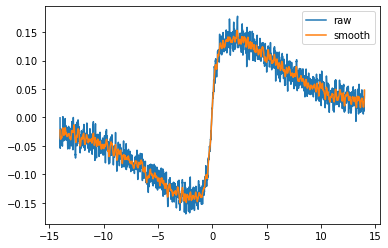

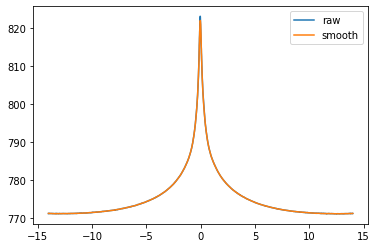

R0 =  821.9954325455509 , B =  -0.022621600000000002
gamma =  3.0343368958587586e-12
3_14T_sweep_5e-5A.csv saved


In [3]:
thickness = 2e-8  # m = 20 nm
width = 2e-5  # m = 20 um
e = 1.602e-19  # C

B_Rxx2omega, thresh_Rxx2omega = 2.5, 0.01
B_gamma, thresh_gamma = 0.2, 0.01

df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "3_14T_sweep_5e-5A.txt")
key = Path(filename).stem

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
fixed_temp = df["Temperature (K)"].mean()
V2omega_raw = df["Lock-in2(Y)"].values
V1omega_raw = -df["Lock-in1(X)"].values
B_ref_u, _, V2omega_u, B_ref_d, _, V2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
B_ref_u, V1omega_u, _, B_ref_d, V1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
# (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

# V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
# V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
temp = np.full_like(B_ref_u, fixed_temp)

current_float = float(key[-5:-1])
print("current= ", current_float)
Rxx2omega_u = V2omega_u / current_float
Rxx2omega_d = V2omega_d / current_float
Rxx1omega_u = V1omega_u / current_float
Rxx1omega_d = V1omega_d / current_float
Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 31, 3)
Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 31, 3)
Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 31, 3)
Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 31, 3)
plt.plot(B_ref_d, Rxx2omega_d, label="raw")
plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
plt.legend()
plt.show()
plt.plot(B_ref_d, Rxx1omega_u, label="raw")
plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
plt.legend()
plt.show()
current = np.full_like(B_ref_u, current_float)
idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]

current_density = current_float / (width * thickness)  # A/m^2

# Rxx1omegaの最大値をR0とする
R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

gamma = (DeltaR / DeltaB) / (current_density * R0)
print("gamma = ", gamma)

Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)
new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": V2omega_u, "V2omega_d": V2omega_d, "V1omega_d": V1omega_d, "V1omega_u": V1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
new_df.to_csv(savedir / (key + ".csv"), index=False)
print(key + ".csv saved")

In [4]:
current_density

124999999.99999999

3_3T_sweep_1e-3A
3_3T_sweep_1e-4A
3_3T_sweep_1e-5A
3_3T_sweep_1e-6A
3_3T_sweep_1e-7A
3_3T_sweep_2e-4A
3_3T_sweep_2e-5A
3_3T_sweep_2e-6A
3_3T_sweep_2e-7A
3_3T_sweep_5e-4A
3_3T_sweep_5e-5A
3_3T_sweep_5e-6A
3_3T_sweep_5e-7A


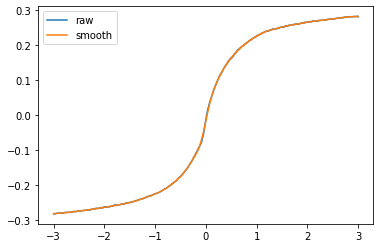

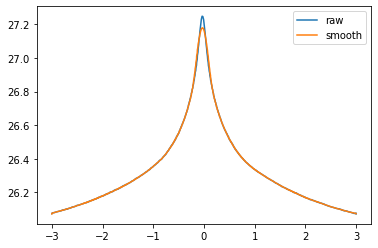

70 2.50943
R0 =  27.17888053219934 , B =  -0.029632799999999997
gamma =  9.12445616122082e-12


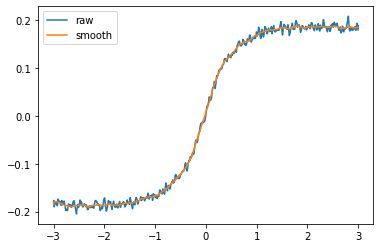

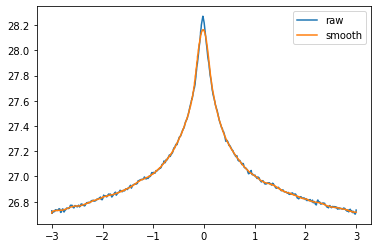

69 2.4991000000000003
R0 =  28.163802300095604 , B =  -0.010641500000000002
gamma =  4.667469220729137e-11


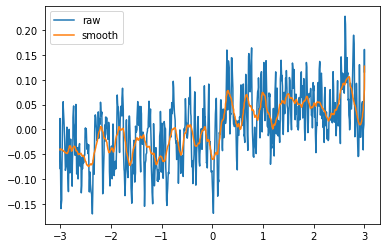

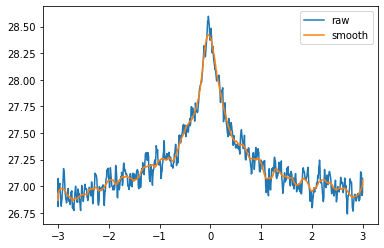

71 2.50006
R0 =  28.421561644451568 , B =  -0.0395681
gamma =  -1.7229906970464387e-10


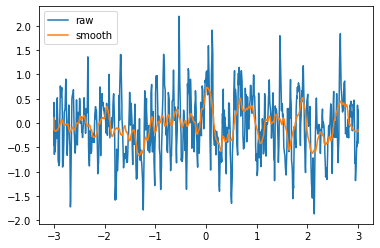

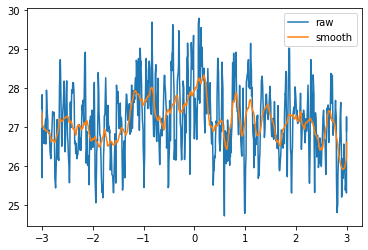

71 2.50374
R0 =  28.34019568216538 , B =  0.18141700000000002
gamma =  1.2624899644161393e-08


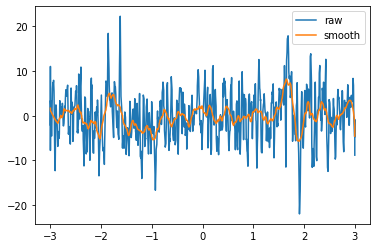

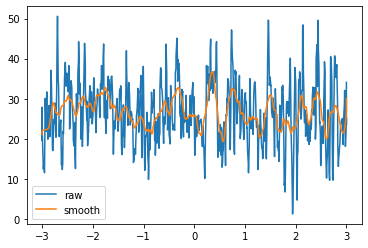

68 2.5087099999999998
R0 =  36.777423823100996 , B =  0.34294
gamma =  -1.6368624169953164e-07


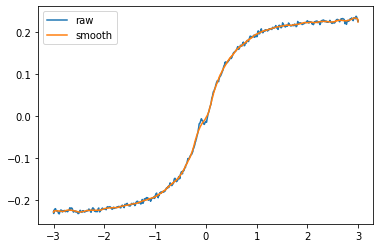

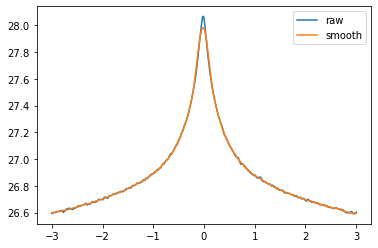

71 2.50571
R0 =  27.981660029976545 , B =  -0.0147136
gamma =  1.9474257004170073e-11


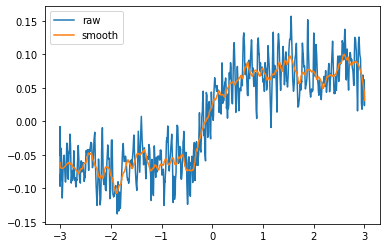

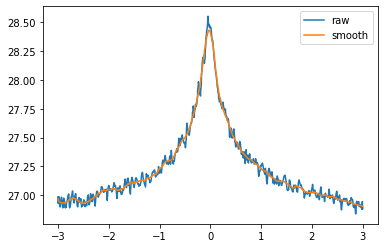

68 2.50991
R0 =  28.430387109779463 , B =  -0.0174325
gamma =  1.189529631258405e-10


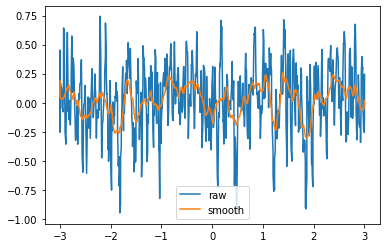

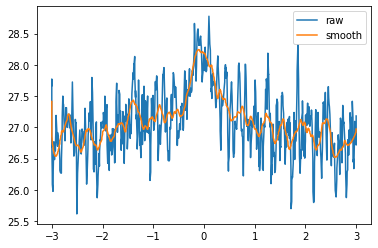

69 2.5007099999999998
R0 =  28.244665712595108 , B =  -0.11011900000000001
gamma =  3.3062714200212785e-09


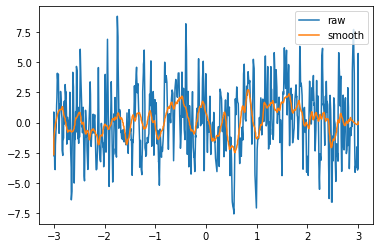

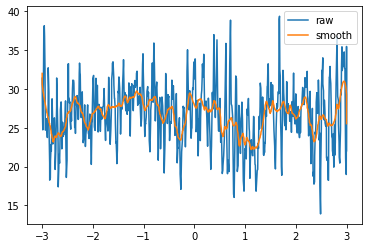

73 2.50488
R0 =  31.998099816770573 , B =  -2.99998
gamma =  -8.36087678724671e-07


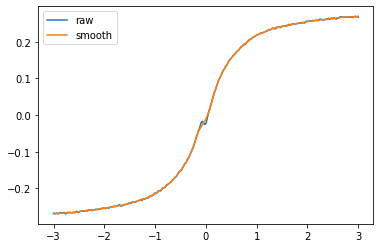

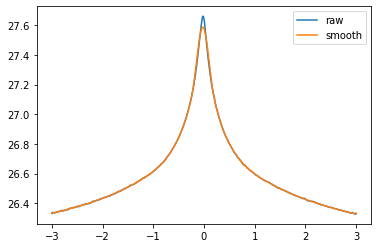

69 2.50988
R0 =  27.58655660838691 , B =  -0.024638300000000002
gamma =  9.142126455198643e-12


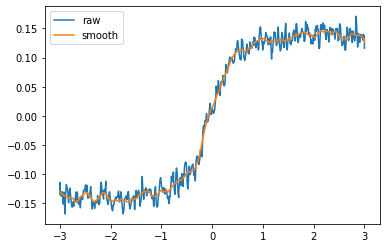

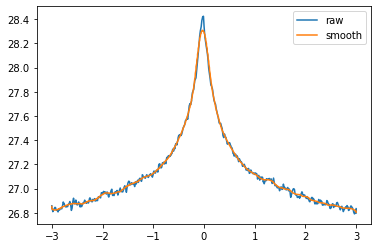

71 2.49786
R0 =  28.30741530534608 , B =  -0.0274859
gamma =  6.064940458066984e-11


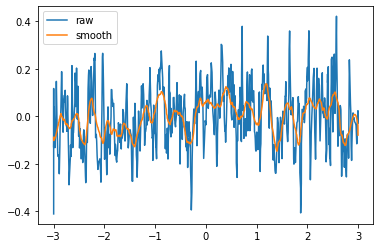

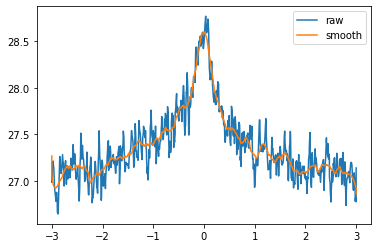

69 2.50374
R0 =  28.600529026413692 , B =  0.00323499
gamma =  -2.371309047609334e-10


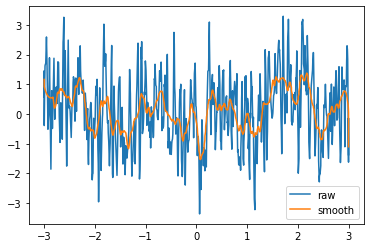

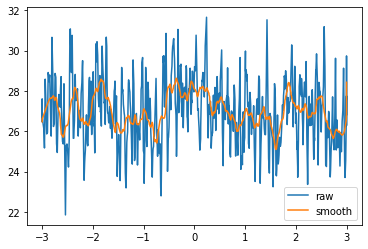

74 2.50983
R0 =  28.635434994980006 , B =  -0.35215700000000005
gamma =  -2.335927166017065e-07
13 13 13 13
Rxx_2.5T_2K_I_dep.csv saved
[2.299995860566449, 2.2999972855591744, 2.3000004872646738, 2.3000052106430156, 2.2999960444444443, 2.299997297895903, 2.3000005094130676, 2.299999844789357, 2.3000079023307443, 2.299997726775956, 2.300000445930881, 2.3000034, 2.300000242825607]


In [5]:
thickness = 2e-8  # m = 20 nm
width = 2e-5  # m = 20 um
e = 1.602e-19  # C

B_Rxx2omega, thresh_Rxx2omega = 2.5, 0.01
B_gamma, thresh_gamma = 0.1, 0.01

df_gamma_name = f"gamma_{B_gamma}T_2K_I_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_2K_I_dep.csv"


df_dict = {}
for filename in sorted(glob(str(datadir / "3_3T_sweep_*e-*A.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    V2omega_raw = df["Lock-in2(Y)"].values
    V1omega_raw = df["Lock-in1(Y)"].values
    B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, V2omega_raw))
    B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, V1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    current_float = float(key[-5:-1])
    Rxx2omega_u = Vxx2omega_u / current_float
    Rxx2omega_d = Vxx2omega_d / current_float
    Rxx1omega_u = Vxx1omega_u / current_float
    Rxx1omega_d = Vxx1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 51, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 51, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 51, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 51, 3)
    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    current_density = current_float / (width * thickness)  # A/m^2
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = (DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Rxx2omega_d_over_R0_B = Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({"temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, "V2omega_u": Vxx2omega_u, "V2omega_d": Vxx2omega_d, "V1omega_d": Vxx1omega_d, "V1omega_u": Vxx1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)

print(len(currents), len(temps), len(Rxx_lowB_means), len(Rxx_lowB_stds))
sort_idx = np.argsort(np.array(currents))
currents_summary, temps_summary, Rxx_lowB_means_summary, Rxx_lowB_stds_summary = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents_summary, "temp": temps_summary, "Rxx_lowB_mean": Rxx_lowB_means_summary, "Rxx_lowB_std": Rxx_lowB_stds_summary})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(currents))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)

,Time (min),Temperature (K),Field (Oe),Position (deg),Lock-in1(X),Lock-in1(Y),Lock-in2(X),Lock-in2(Y),Current(X),Current(Y)\n
0,182.672,2.30008,30000.2,0.0,-0.757695,0.026077,0.000075,0.001220,0.0,0.0
1,182.712,2.29992,30000.2,0.0,-0.757693,0.026077,0.000075,0.001220,0.0,0.0
2,182.747,2.29960,30000.2,0.0,-0.757694,0.026078,0.000077,0.001221,0.0,0.0
3,182.780,2.30030,30000.2,0.0,-0.757693,0.026077,0.000075,0.001220,0.0,0.0
4,182.813,2.30022,30000.2,0.0,-0.757689,0.026073,0.000075,0.001220,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
913,212.955,2.30056,29999.4,0.0,-0.757657,0.026074,0.000078,0.001219,0.0,0.0
914,212.983,2.29962,29999.4,0.0,-0.757658,0.026073,0.000076,0.001221,0.0,0.0
915,213.017,2.30046,29999.4,0.0,-0.757660,0.026073,0.000075,0.001220,0.0,0.0
916,213.051,2.29954,29999.4,0.0,-0.757655,0.026073,0.000076,0.001220,0.0,0.0
